In [1]:
# Magic Words
from __future__ import annotations
import matplotlib as mpl
import matplotlib.pyplot as plt  # noqa: F401
import seaborn as sns
import numpy as np  # noqa: F401
import pandas as pd
from collections import defaultdict, Counter  # noqa: F401
from typing import Tuple, List, Dict, Union, Optional  # noqa: F401
from IPython.display import display, Markdown

%matplotlib inline
%load_ext wurlitzer
mpl.rcParams["font.family"] = "Noto Sans JP"
sns.set(font=["Noto Sans JP"], font_scale=1.5)
pd.set_option("display.date_yearfirst", True)
pd.set_option("display.float_format", "{:.4f}".format)


# The function displays Table or Text even inside function
def show_it(
    data: Union[str, pd.DataFrame],
    demical: Optional[int] = 4,
) -> None:
    if isinstance(data, pd.DataFrame):
        display(
            Markdown(data.to_markdown(floatfmt=f".{demical}f", intfmt=","))
        )
    else:
        display(Markdown(data.strip()))
    return

In [2]:
from gensim.models.keyedvectors import KeyedVectors

kvs: Dict[str, Dict[int, KeyedVectors]] = dict()
kvs["surface"] = dict()
kvs["surface"][200] = KeyedVectors.load_word2vec_format(
    "../kv_fasttext_jawiki_20230101_dim200.bin",
    binary=True,
)
kvs["surface"][300] = KeyedVectors.load_word2vec_format(
    "../kv_fasttext_jawiki_20230101_dim300.bin",
    binary=True,
)
kvs["base"] = dict()
kvs["base"][200] = KeyedVectors.load_word2vec_format(
    "../kv_fasttext_jawiki_base_20230101_dim200.bin",
    binary=True,
)
kvs["base"][300] = KeyedVectors.load_word2vec_format(
    "../kv_fasttext_jawiki_base_20230101_dim300.bin",
    binary=True,
)

In [3]:
from fugashi import GenericTagger
import unidic_cwj

tagger: GenericTagger = GenericTagger(
    f"-d {unidic_cwj.dicdir} -r {unidic_cwj.dicdir}/dicrc"
)

In [4]:
from typing import NamedTuple


class Story(NamedTuple):
    did: str
    label: List[str]
    name: str
    contents: List[str]

In [5]:
import json

stories: List[Story] = list()
with open("ldcc.jsonl", "rt") as rf:
    line: str = rf.readline()
    while line:
        story: Story = Story(**json.loads(line))
        stories.append(story)
        line = rf.readline()

In [6]:
class Morpheme(NamedTuple):
    surface: str
    pos1: str
    pos2: str
    pos3: str
    pos4: str
    orthBase: str
    kana: str
    dic: str

In [7]:
def is_taigen(mor: Morpheme) -> bool:
    if mor.pos1 == "名詞":
        if mor.pos2 == "数詞":
            return False
        elif mor.pos2 == "普通名詞" and mor.pos3 == "助数詞可能":
            return False
        return True
    return False


def is_taiyo(mor: Morpheme) -> bool:
    if mor.pos1 in ["動詞", "形容詞", "形状詞"]:
        return True
    return is_taigen(mor=mor)

In [8]:
import re
from re import Match


def node2mor(node: str) -> Morpheme:
    mor: Morpheme
    match: Optional[Match]
    while True:
        match = re.search(
            r':"[^:,]*?(?<!\\)(")[^:,]*?",', node
        )
        if match is None:
            break
        start: int = match.start(1)
        node = node[:start] + "\\" + node[start:]
    try:
        mor = Morpheme(**json.loads(node))
    except Exception as e:
        match = re.match(
            r'^{"surface":"(.*?)","pos1":"', node
        )
        if match is None:
            raise e
        mor = Morpheme(
            surface=match.group(1),
            pos1="記号",
            pos2="一般",
            pos3="",
            pos4="",
            orthBase="",
            kana="",
            dic="UNK",
        )
    return mor

In [9]:
class VariousCorpus(NamedTuple):
    surface_all: Dict[str, str] = dict()
    surface_taiyo: Dict[str, str] = dict()
    base_all: Dict[str, str] = dict()
    base_taiyo: Dict[str, str] = dict()
    taigen: Dict[str, str] = dict()

In [10]:
various_corpus: VariousCorpus = VariousCorpus()
for story in stories:
    surface_all: List[str] = list()
    surface_taiyo: List[str] = list()
    base_all: List[str] = list()
    base_taiyo: List[str] = list()
    taigen: List[str] = list()
    for content in story.contents:
        for node in tagger.parse(content).splitlines():
            if node == "EOS":
                break
            mor: Morpheme = node2mor(node=node)
            base: str = mor.orthBase if mor.dic != "UNK" else mor.surface
            surface_all.append(mor.surface)
            base_all.append(base)
            if is_taigen(mor=mor):
                taigen.append(mor.surface)
            if is_taiyo(mor=mor):
                surface_taiyo.append(mor.surface)
                base_taiyo.append(base)
    various_corpus.surface_all[story.did] = " ".join(surface_all)
    various_corpus.surface_taiyo[story.did] = " ".join(surface_taiyo)
    various_corpus.base_all[story.did] = " ".join(base_all)
    various_corpus.base_taiyo[story.did] = " ".join(base_taiyo)
    various_corpus.taigen[story.did] = " ".join(taigen)

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidfs: Dict = dict()
tfidfs["surface_all"] = TfidfVectorizer().fit(
    list(various_corpus.surface_all.values())
)
tfidfs["surface_taiyo"] = TfidfVectorizer().fit(
    list(various_corpus.surface_taiyo.values())
)
tfidfs["base_all"] = TfidfVectorizer().fit(
    list(various_corpus.base_all.values())
)
tfidfs["base_taiyo"] = TfidfVectorizer().fit(
    list(various_corpus.base_taiyo.values())
)
tfidfs["taigen"] = TfidfVectorizer().fit(
    list(various_corpus.taigen.values())
)

In [12]:
for ctype, tfidf in tfidfs.items():
    print(f"{ctype}: {tfidf.stop_words_}")

surface_all: set()
surface_taiyo: set()
base_all: set()
base_taiyo: set()
taigen: set()


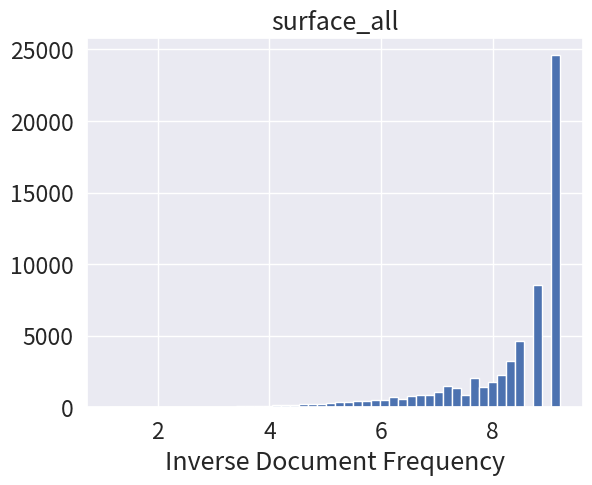

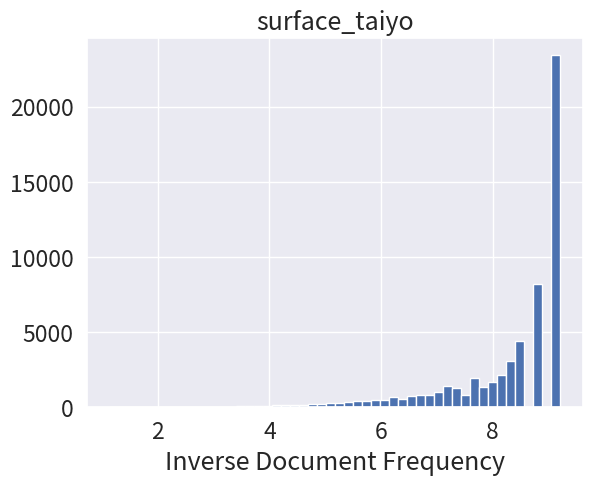

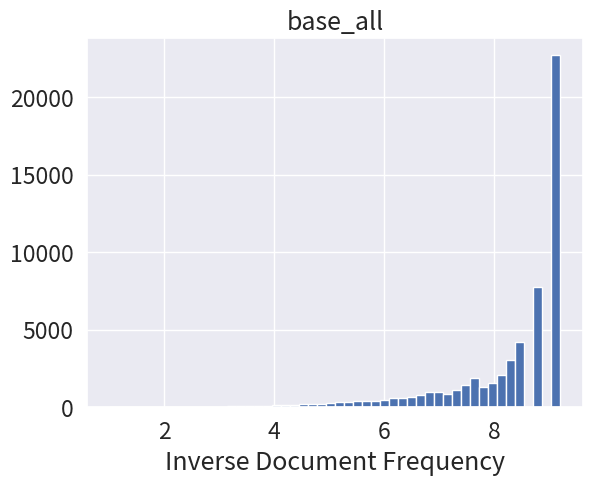

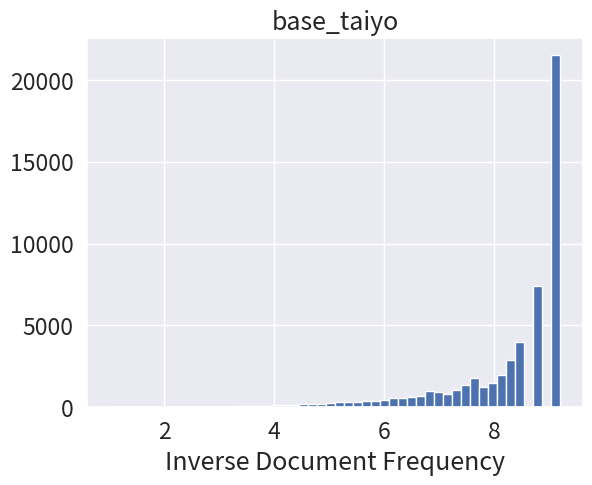

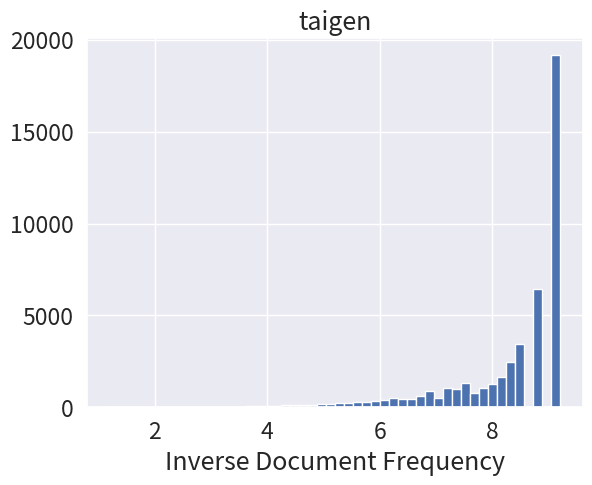

In [13]:
for ctype, tfidf in tfidfs.items():
    pd.Series(tfidf.idf_).hist(bins=50)
    plt.title(ctype)
    plt.xlabel("Inverse Document Frequency")
    plt.show()
    plt.clf()
    plt.close()

In [14]:
# threshold of Inverse Document Frequency
idf_threshold: float = 6.0

In [15]:
for ctype, tfidf in tfidfs.items():
    nvocab: int = len(tfidf.vocabulary_)
    nstop: int = np.where(tfidf.idf_ < idf_threshold, 1, 0).sum()
    rate: float = round(nstop / nvocab, 5)
    print(
        f"{ctype}: vocab={nvocab}, nstop={nstop}, rate={rate}"
    )

surface_all: vocab=61484, nstop=4132, rate=0.0672
surface_taiyo: vocab=58455, nstop=3758, rate=0.06429
base_all: vocab=56709, nstop=3928, rate=0.06927
base_taiyo: vocab=53688, nstop=3574, rate=0.06657
taigen: vocab=46045, nstop=2695, rate=0.05853


In [16]:
stopwords: Dict[str, List[str]] = dict()
for ctype, tfidf in tfidfs.items():
    id2word: Dict[int, str] = dict()
    for word, wid in tfidf.vocabulary_.items():
        id2word[wid] = word
    swds: List[str] = [
        id2word[x] for x in np.where(tfidf.idf_ < idf_threshold)[0]
    ]
    stopwords[ctype] = swds

In [17]:
def corpus2vectors(
    title: str,
    svs: Dict[str, Dict[str, np.ndarray]],
    cpus: Dict[str, str],
    pkvs: Dict[int, KeyedVectors],
    swds: List[str],
) -> None:
    for did, corpus in cpus.items():
        all_vec200 = np.zeros(200)
        all_vec300 = np.zeros(300)
        stop_vec200 = np.zeros(200)
        stop_vec300 = np.zeros(300)
        for word in corpus.split():
            is_stop: bool = word in swds
            try:
                v200: np.ndarray = pkvs[200].get_vector(word)
            except Exception:
                pass
            else:
                all_vec200 += v200
                if not is_stop:
                    stop_vec200 += v200
            try:
                v300: np.ndarray = pkvs[300].get_vector(word)
            except Exception:
                pass
            else:
                all_vec300 += v300
                if not is_stop:
                    stop_vec300 += v300
        all_vec200 /= np.clip(
            np.linalg.norm(all_vec200, ord=2), 1e-9, None
        )
        stop_vec200 /= np.clip(
            np.linalg.norm(stop_vec200, ord=2), 1e-9, None
        )
        all_vec300 /= np.clip(
            np.linalg.norm(all_vec300, ord=2), 1e-9, None
        )
        stop_vec300 /= np.clip(
            np.linalg.norm(stop_vec300, ord=2), 1e-9, None
        )
        svs[f"{title}_all_200"][did] = all_vec200
        svs[f"{title}_stop_200"][did] = stop_vec200
        svs[f"{title}_all_300"][did] = all_vec300
        svs[f"{title}_stop_300"][did] = stop_vec300
    return

In [18]:
story_vectors: Dict[str, Dict[str, np.ndarray]] = defaultdict(dict)

corpus2vectors(
    title="surface_all",
    svs=story_vectors,
    cpus=various_corpus.surface_all,
    pkvs=kvs["surface"],
    swds=stopwords["surface_all"],
)
corpus2vectors(
    title="surface_taiyo",
    svs=story_vectors,
    cpus=various_corpus.surface_taiyo,
    pkvs=kvs["surface"],
    swds=stopwords["surface_taiyo"],
)
corpus2vectors(
    title="base_all",
    svs=story_vectors,
    cpus=various_corpus.base_all,
    pkvs=kvs["base"],
    swds=stopwords["base_all"],
)
corpus2vectors(
    title="base_taiyo",
    svs=story_vectors,
    cpus=various_corpus.base_taiyo,
    pkvs=kvs["base"],
    swds=stopwords["base_taiyo"],
)
corpus2vectors(
    title="taigen",
    svs=story_vectors,
    cpus=various_corpus.taigen,
    pkvs=kvs["base"],
    swds=stopwords["taigen"],
)

In [19]:
from sklearn.manifold import TSNE

planes: Dict[str, pd.DataFrame] = dict()
for ctype, dvecs in story_vectors.items():
    ovecs: np.ndarray = np.array(list(dvecs.values()))
    plane = TSNE(n_components=2, random_state=12, n_jobs=-1).fit_transform(
        ovecs
    )
    plane = pd.DataFrame(plane, columns=["x1", "x2"])
    plane = plane.assign(label=[x.label[0] for x in stories])
    planes[ctype] = plane

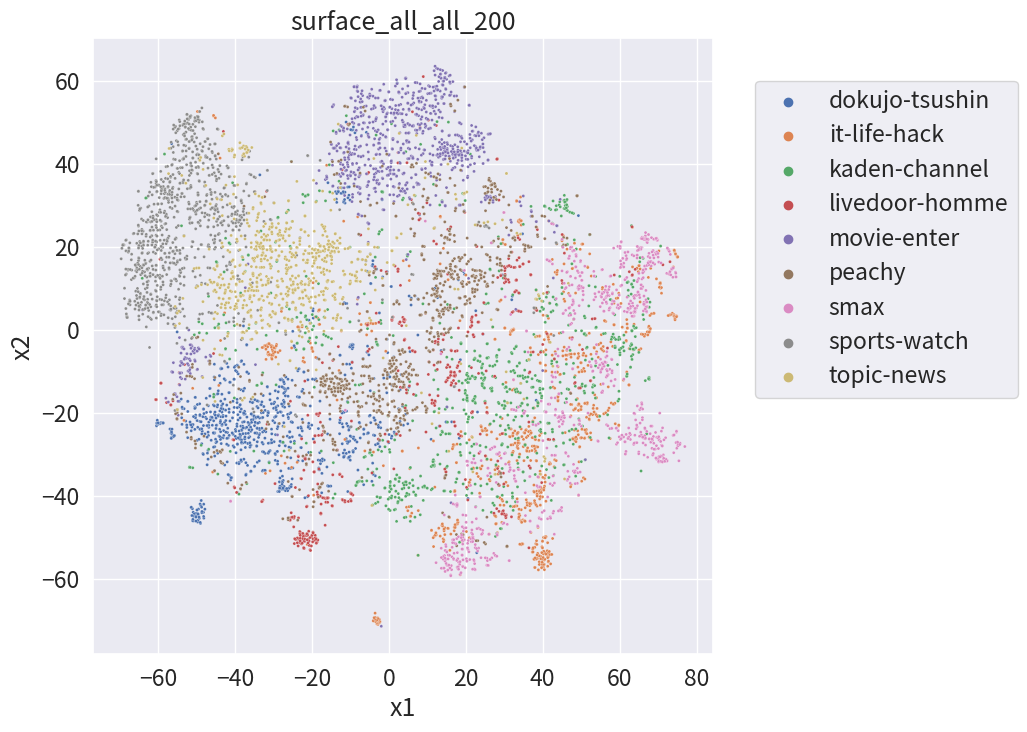

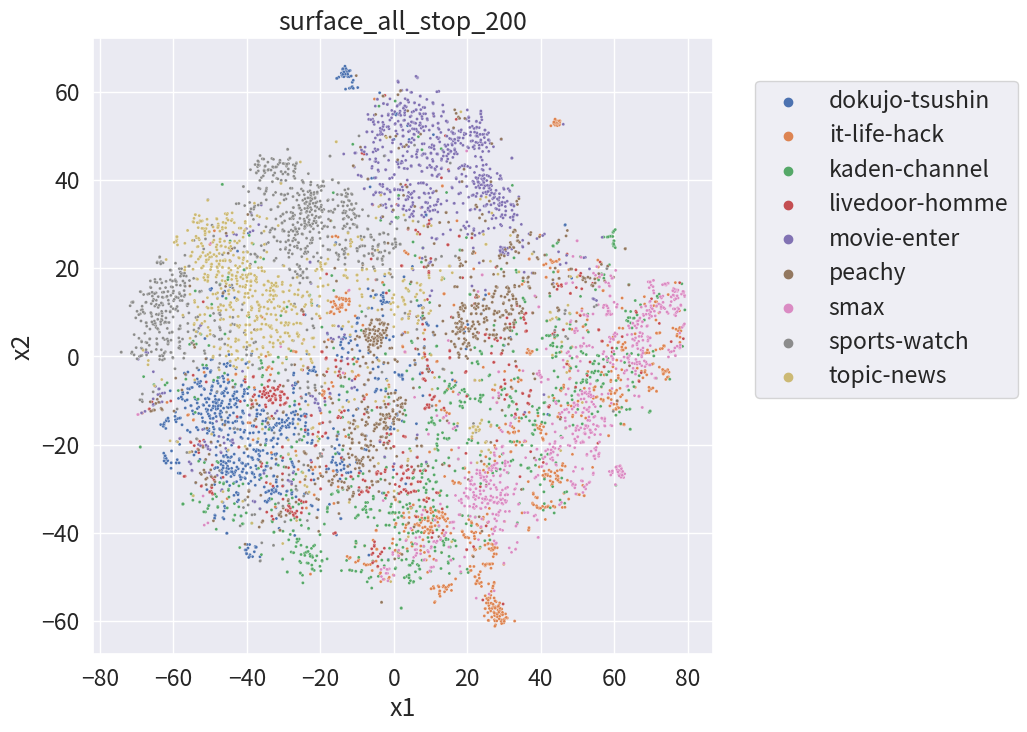

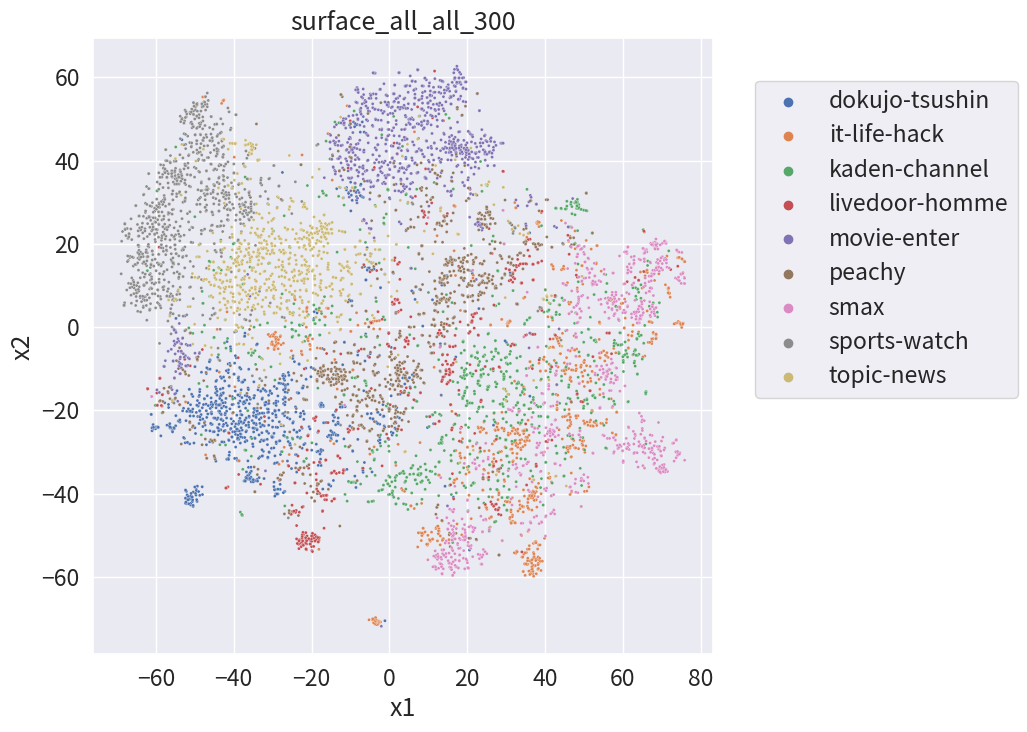

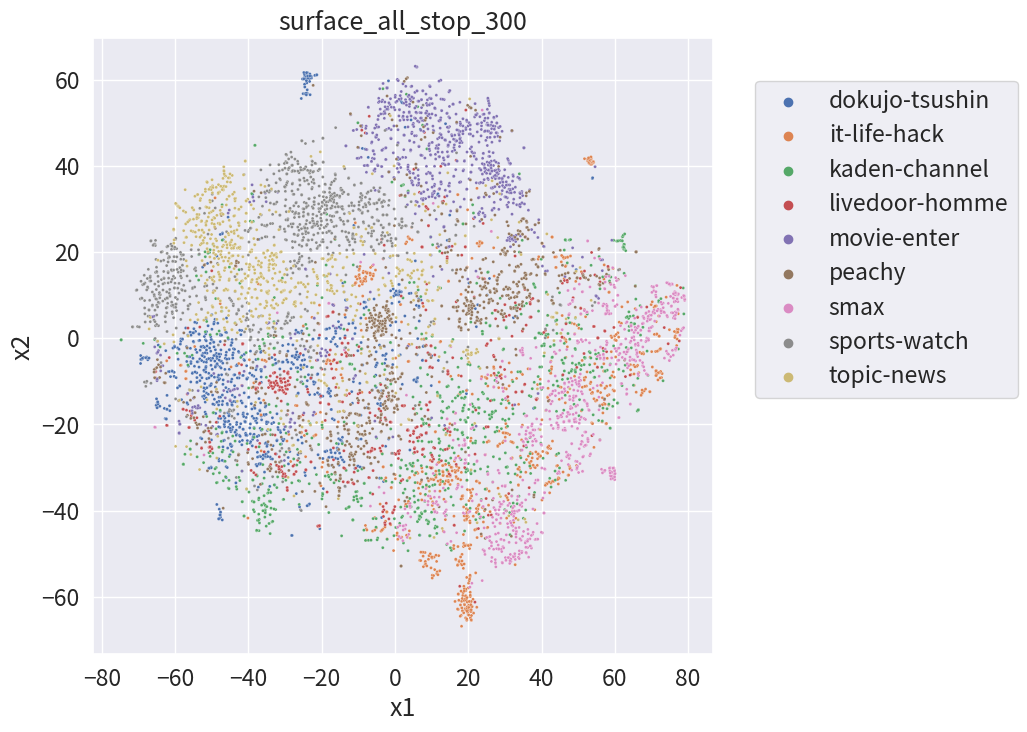

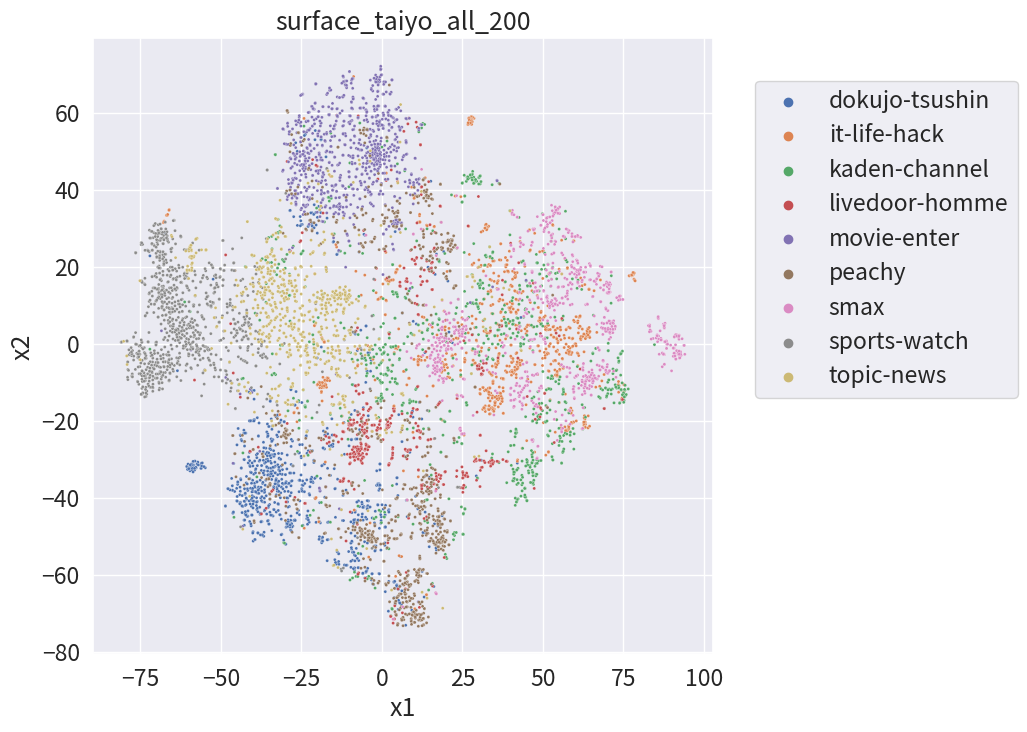

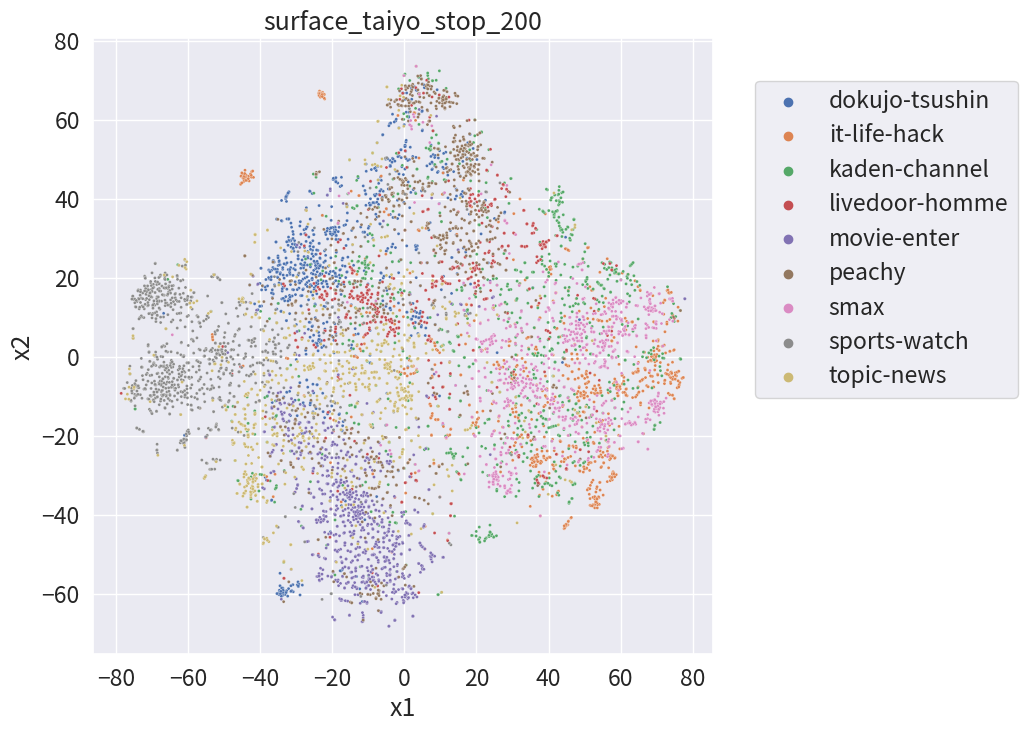

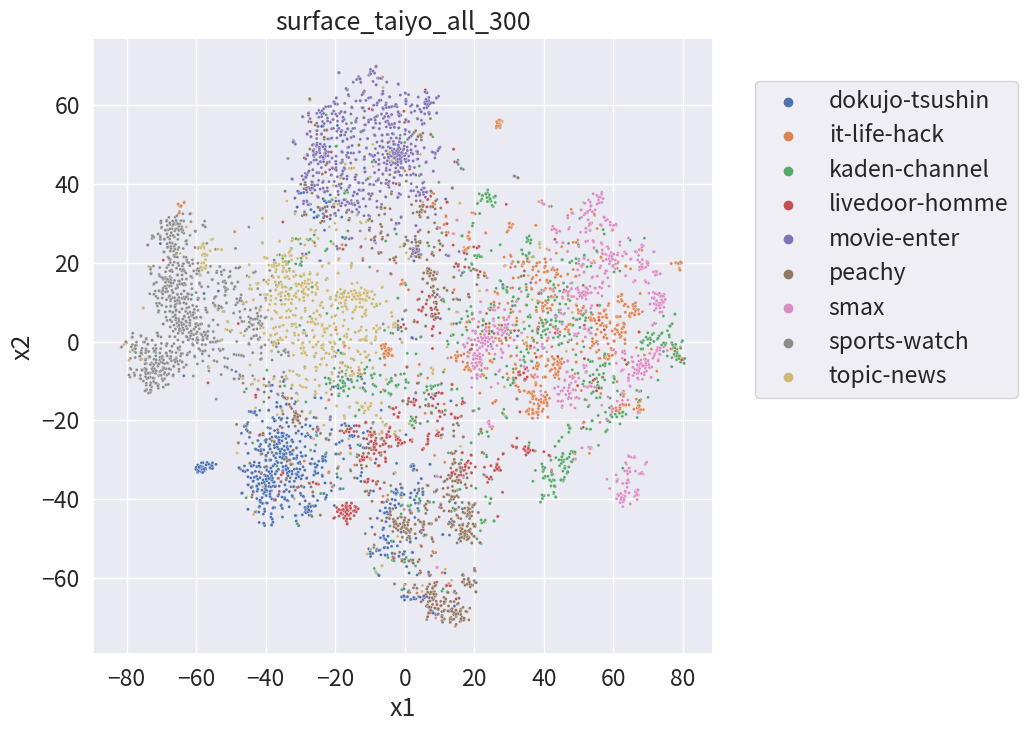

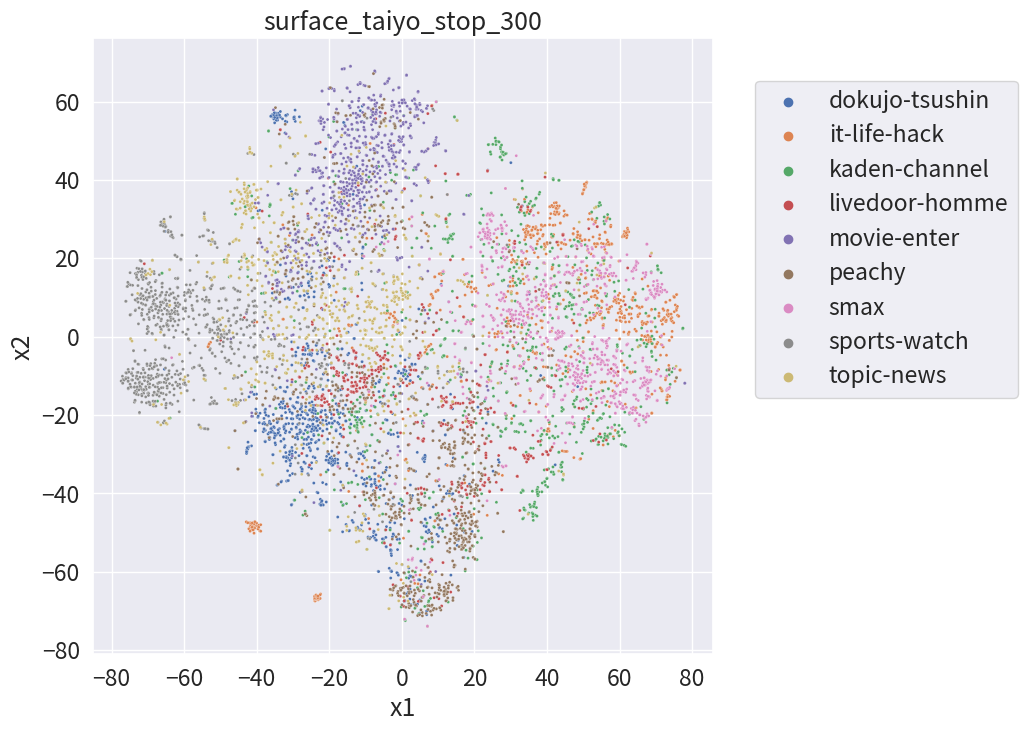

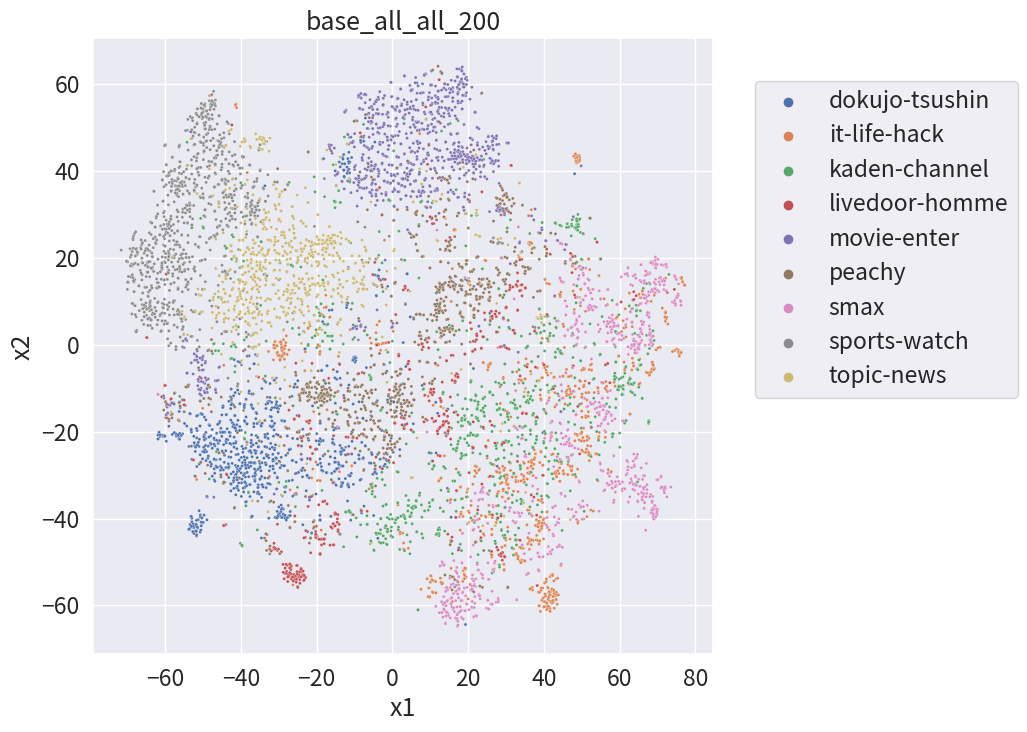

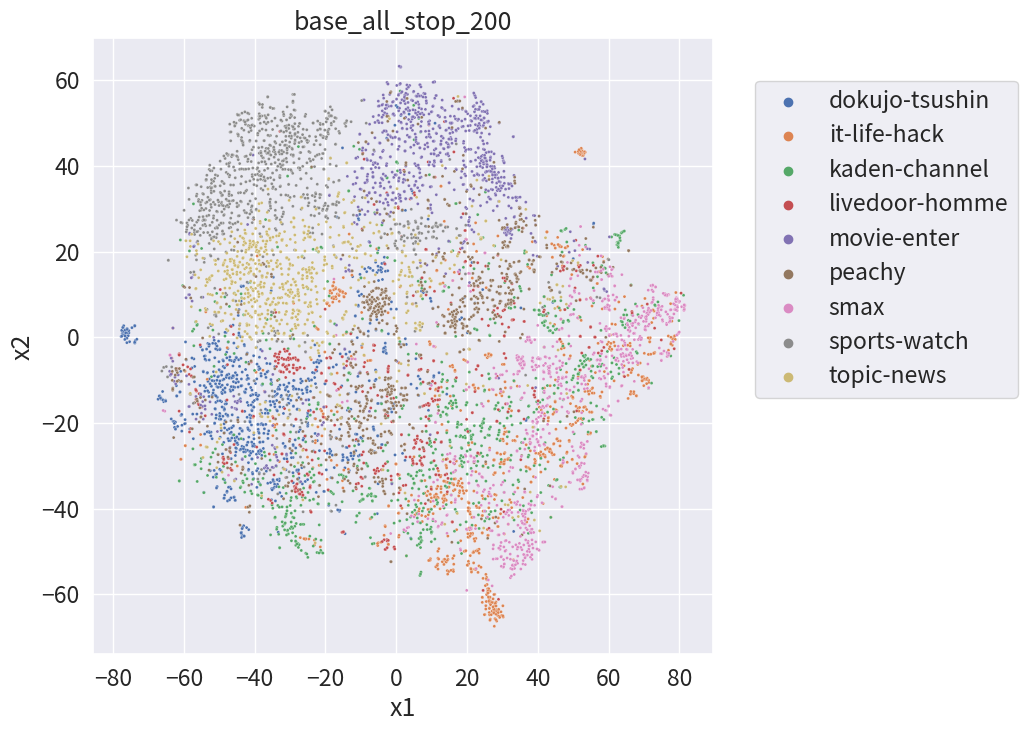

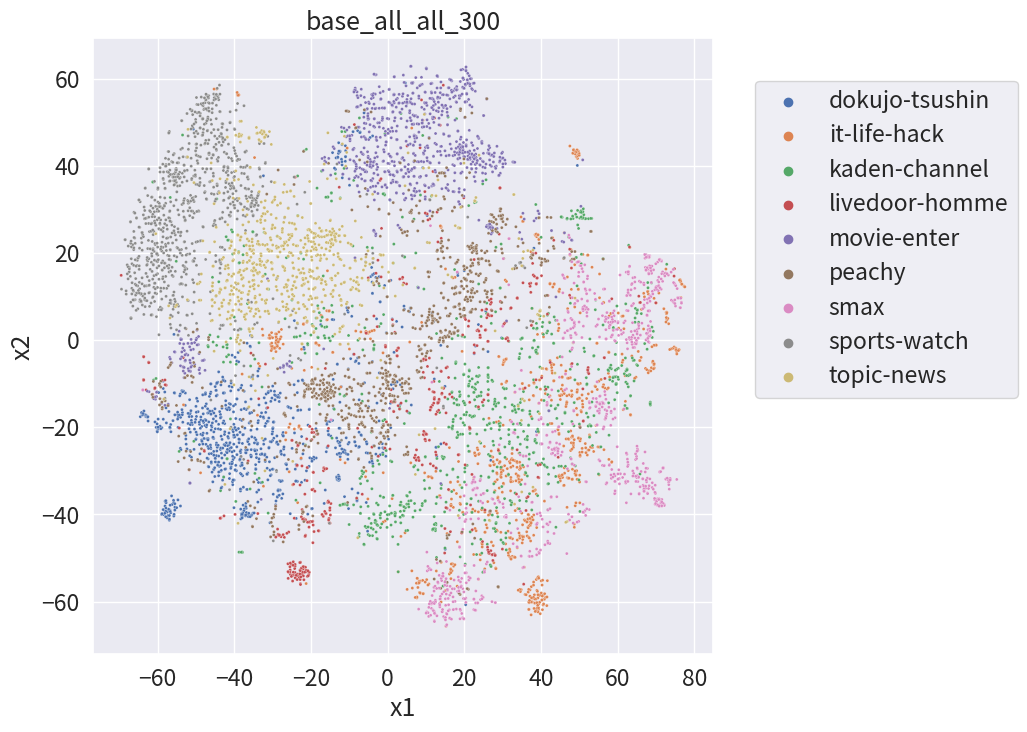

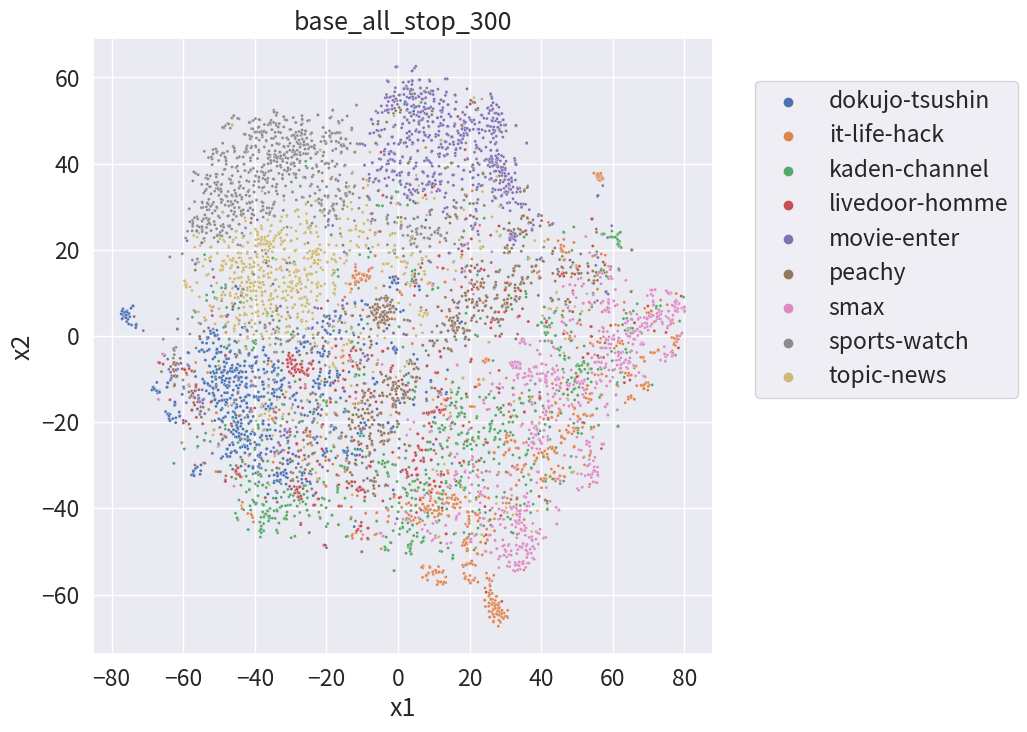

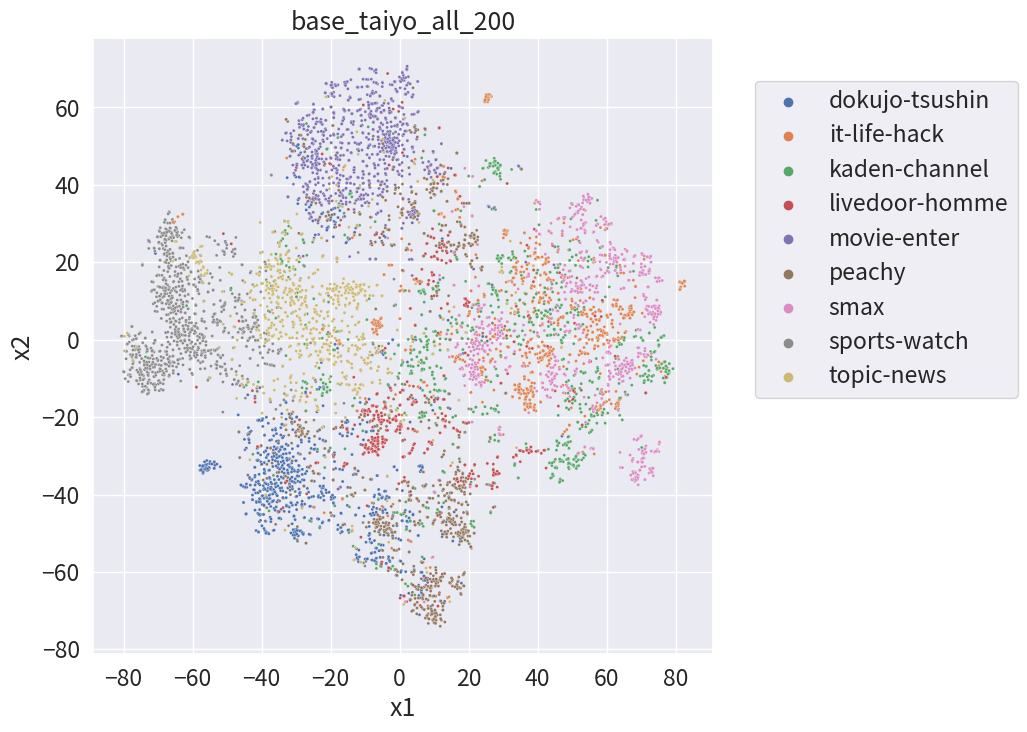

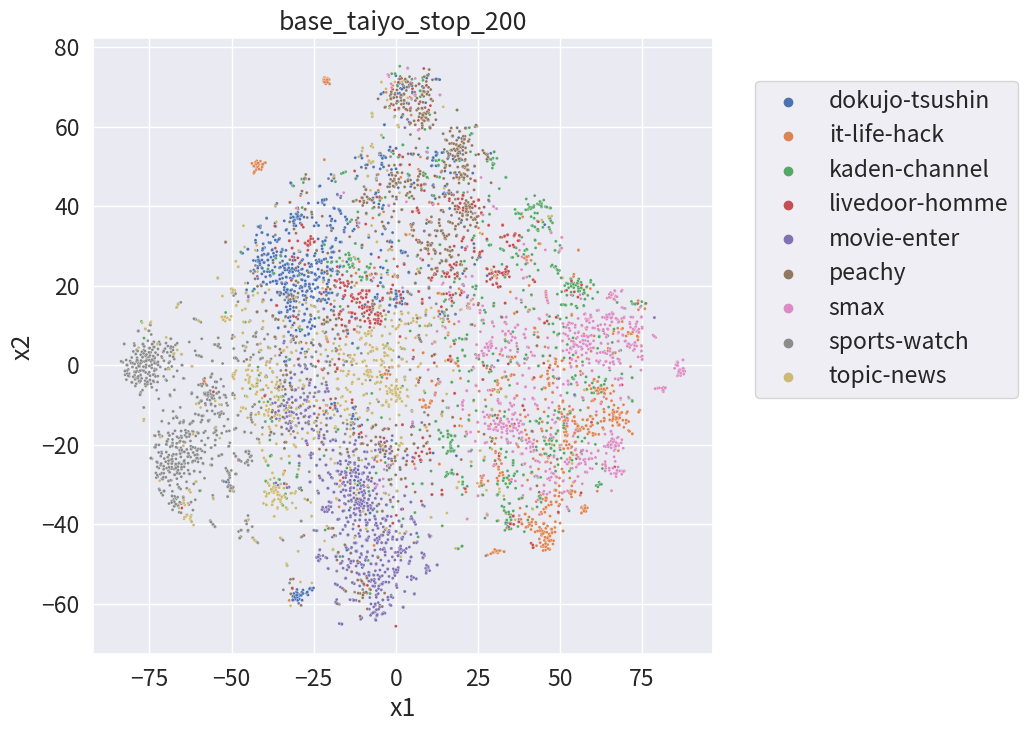

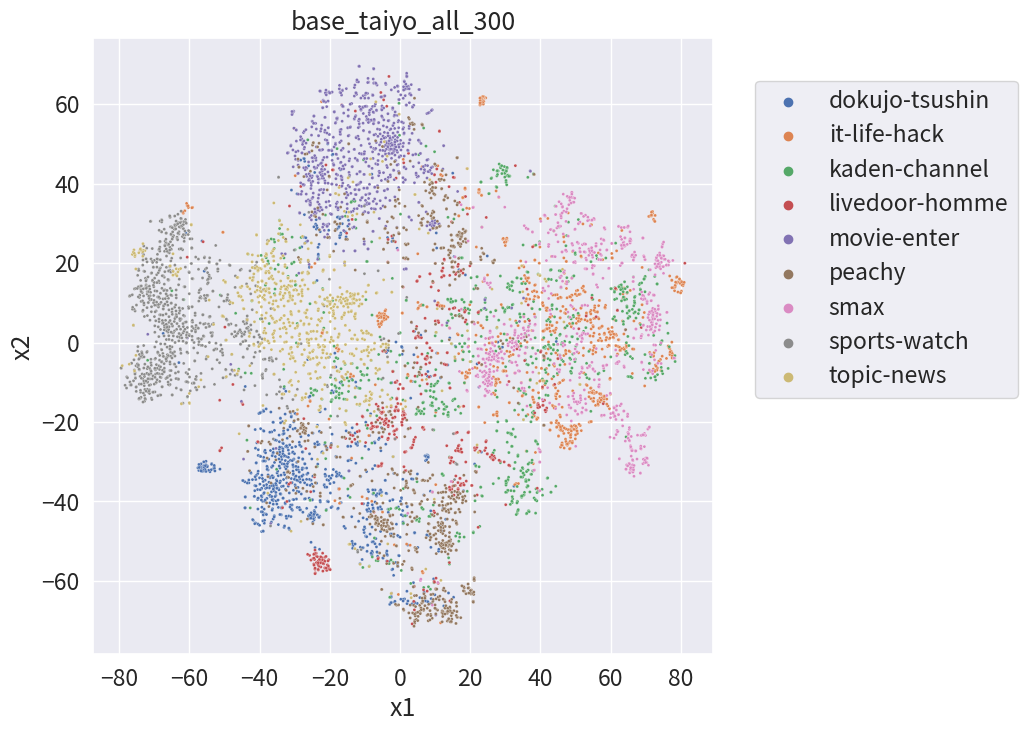

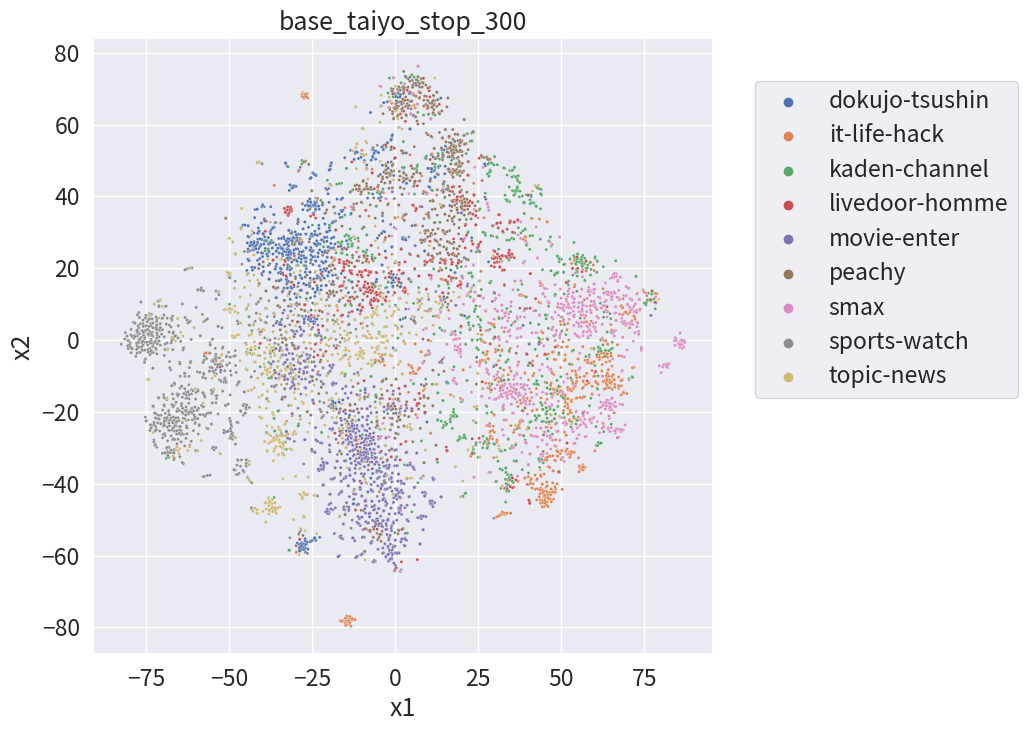

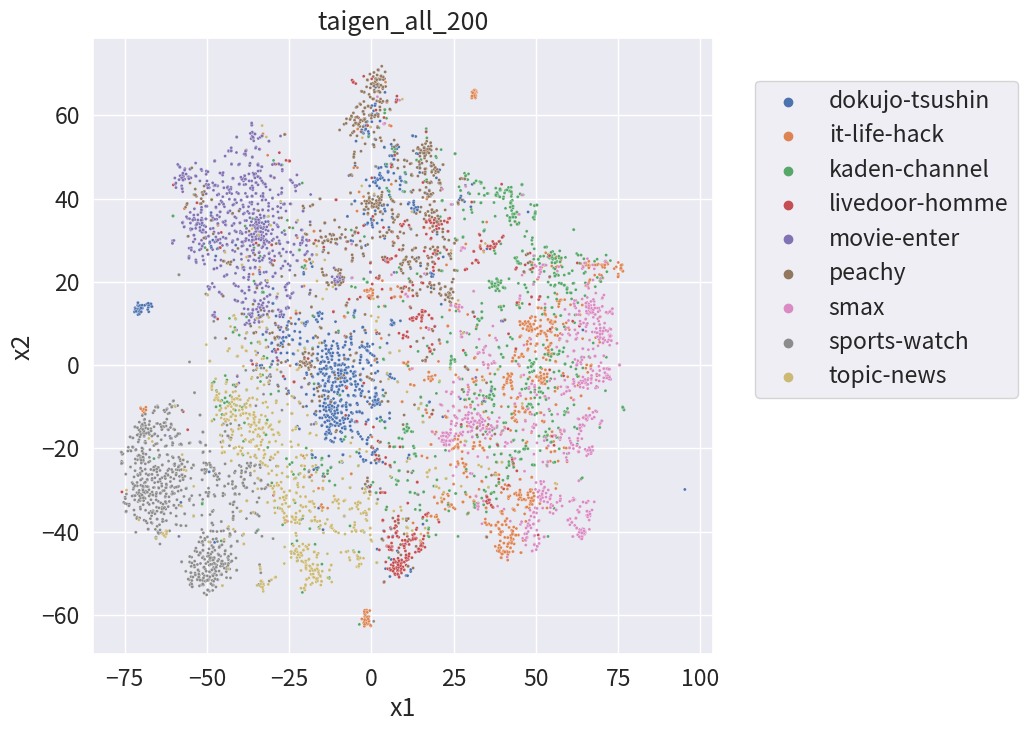

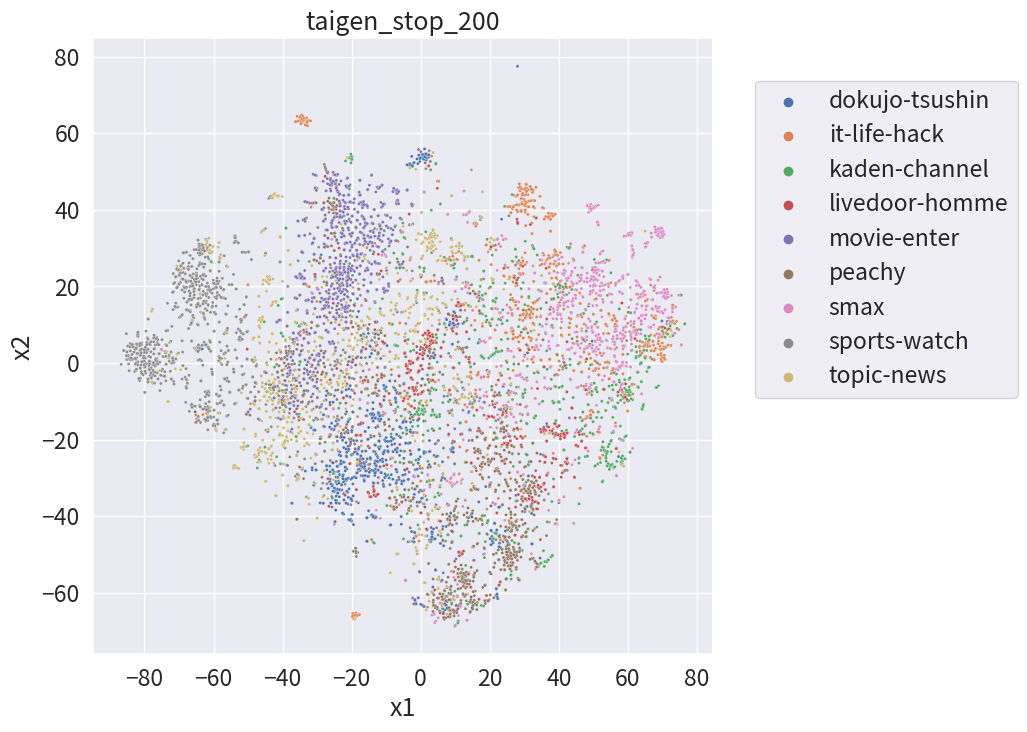

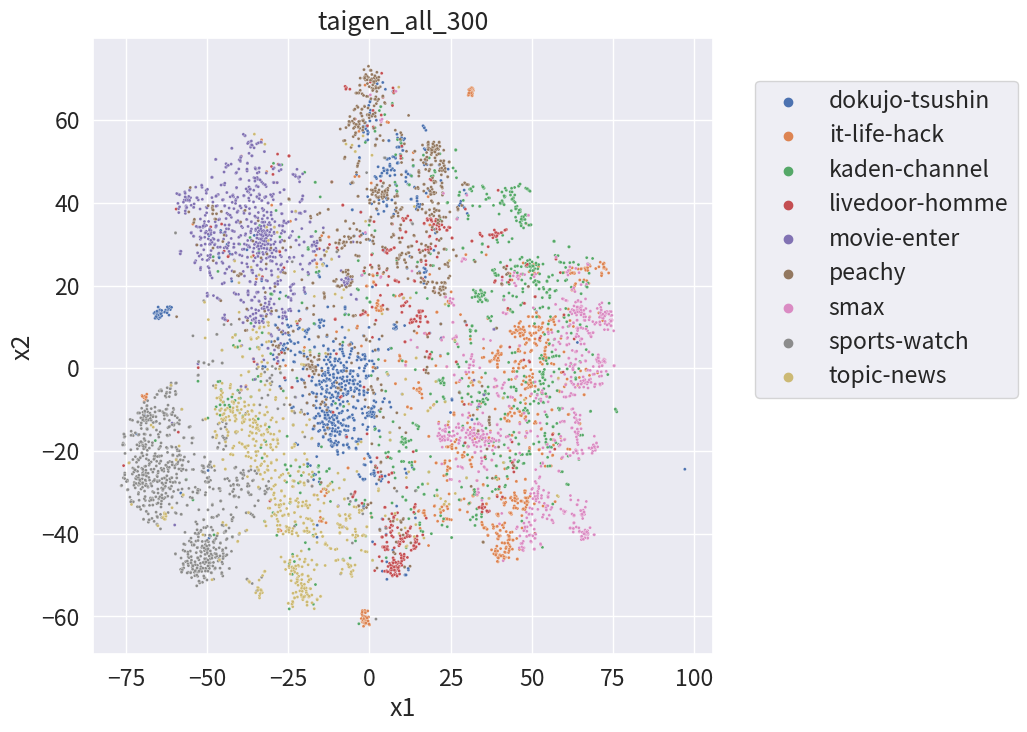

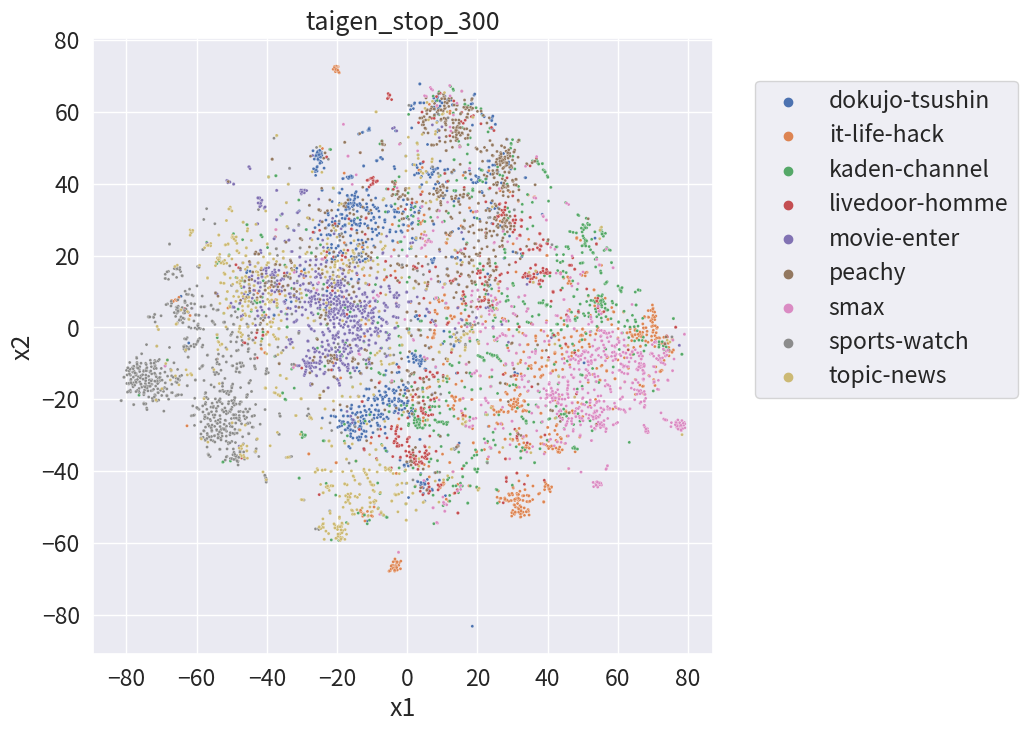

In [20]:
for ctype, plane in planes.items():
    fix, ax = plt.subplots(figsize=(8, 8))
    sns.scatterplot(data=plane, x="x1", y="x2", hue="label", s=5, ax=ax)
    plt.title(ctype)
    plt.legend(bbox_to_anchor=(1.05, 0.95), loc="upper left")
    plt.show()
    plt.clf()
    plt.close()

In [21]:
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder().fit(
    list(set(sorted([x.label[0] for x in stories])))
)
label_encoder.classes_

array(['dokujo-tsushin', 'it-life-hack', 'kaden-channel',
       'livedoor-homme', 'movie-enter', 'peachy', 'smax', 'sports-watch',
       'topic-news'], dtype='<U14')

In [22]:
def create_result_dataframe(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    labels: List[str],
    title: str,
    C: float,
) -> pd.DataFrame:
    result: pd.DataFrame = pd.DataFrame(classification_report(
        y_true, y_pred, target_names=labels,
        output_dict=True, zero_division=0
    )).loc[["f1-score"], labels]
    result = result.assign(
        average=result.mean(axis="columns")
    )
    result = result.assign(C=[C]).T
    result.columns = [title]
    return result

In [23]:
import warnings
from sklearn.exceptions import ConvergenceWarning


warnings.simplefilter("ignore", ConvergenceWarning)

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report


results_train: List[pd.DataFrame] = list()
results_test: List[pd.DataFrame] = list()
results_all: List[pd.DataFrame] = list()
for ctype, dvecs in story_vectors.items():
    print(ctype)
    X: np.ndarray = np.array(list(dvecs.values()))
    y: np.ndarray = label_encoder.transform([x.label[0] for x in stories])
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, shuffle=True, stratify=y, random_state=12
    )
    param: Dict = {
        "C": [0.01, 0.1, 1, 5, 10, 15, 20, 25, 30, 35, 50],
    }
    svc: LinearSVC = LinearSVC(random_state=12)
    skf: StratifiedKFold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=12
    )
    scv: GridSearchCV = GridSearchCV(
        svc, param, cv=skf, scoring="f1_macro", refit=True, n_jobs=-1
    ).fit(X_train, y_train)
    pred_y_train = scv.best_estimator_.predict(X_train)
    result_train: pd.DataFrame = create_result_dataframe(
        y_true=y_train, y_pred=pred_y_train,
        labels=label_encoder.classes_.tolist(),
        title=ctype, C=scv.best_params_["C"],
    )
    results_train.append(result_train)
    pred_y_test = scv.best_estimator_.predict(X_test)
    result_test: pd.DataFrame = create_result_dataframe(
        y_true=y_test, y_pred=pred_y_test,
        labels=label_encoder.classes_.tolist(),
        title=ctype, C=scv.best_params_["C"],
    )
    results_test.append(result_test)
    pred_y = scv.best_estimator_.predict(X)
    result_all: pd.DataFrame = create_result_dataframe(
        y_true=y, y_pred=pred_y,
        labels=label_encoder.classes_.tolist(),
        title=ctype, C=scv.best_params_["C"],
    )
    results_all.append(result_all)

surface_all_all_200


/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear fail

surface_all_stop_200


/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear fail

surface_all_all_300


/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear fail

surface_all_stop_300


/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear fail

surface_taiyo_all_200


/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear fail

surface_taiyo_stop_200


/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear fail

surface_taiyo_all_300


/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear fail

surface_taiyo_stop_300


/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear fail

base_all_all_200


/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear fail

base_all_stop_200


/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear fail

base_all_all_300


/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear fail

base_all_stop_300


/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear fail

base_taiyo_all_200


/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear fail

base_taiyo_stop_200


/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear fail

base_taiyo_all_300


/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear fail

base_taiyo_stop_300


/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear fail

taigen_all_200


/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear fail

taigen_stop_200


/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear fail

taigen_all_300


/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear fail

taigen_stop_300


/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jupyter/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear fail

In [25]:
pd.concat(results_train, axis=1)

surface_all_all_200  surface_all_stop_200  \
dokujo-tsushin               0.8903                0.8653   
it-life-hack                 0.8930                0.8569   
kaden-channel                0.8540                0.8182   
livedoor-homme               0.8030                0.7251   
movie-enter                  0.9494                0.9264   
peachy                       0.8731                0.8231   
smax                         0.9481                0.9217   
sports-watch                 0.9640                0.9461   
topic-news                   0.9346                0.9126   
average                      0.9011                0.8662   
C                           50.0000               35.0000   

                surface_all_all_300  surface_all_stop_300  \
dokujo-tsushin               0.9007                0.8959   
it-life-hack                 0.9325                0.9158   
kaden-channel                0.8842                0.8795   
livedoor-homme               0.8435                0.7768   
movie-enter                  0.9482                0.9416   
peachy                       0.8849                0.8552   
smax                         0.9611                0.9522   
sports-watch                 0.9709                0.9601   
topic-news                   0.9418                0.9338   
average                      0.9186                0.9012   
C                           25.0000               50.0000   

                surface_taiyo_all_200  surface_taiyo_stop_200  \
dokujo-tsushin                 0.8443                  0.7984   
it-life-hack                   0.8593                  0.7910   
kaden-channel                  0.8024                  0.7149   
livedoor-homme                 0.7736                  0.6780   
movie-enter                    0.9434                  0.9082   
peachy                         0.8228                  0.7326   
smax                           0.9211                  0.8621   
sports-watch                   0.9649                  0.9252   
topic-news                     0.9194                  0.8307   
average                        0.8724                  0.8046   
C                             10.0000                  5.0000   

                surface_taiyo_all_300  surface_taiyo_stop_300  \
dokujo-tsushin                 0.8792                  0.8470   
it-life-hack                   0.8926                  0.8476   
kaden-channel                  0.8514                  0.7691   
livedoor-homme                 0.8154                  0.7613   
movie-enter                    0.9560                  0.9285   
peachy                         0.8677                  0.8094   
smax                           0.9502                  0.8952   
sports-watch                   0.9750                  0.9435   
topic-news                     0.9426                  0.8695   
average                        0.9033                  0.8524   
C                             15.0000                  5.0000   

                base_all_all_200  base_all_stop_200  base_all_all_300  \
dokujo-tsushin            0.8828             0.8610            0.9076   
it-life-hack              0.8733             0.8569            0.9362   
kaden-channel             0.8378             0.8127            0.8919   
livedoor-homme            0.7988             0.7344            0.8529   
movie-enter               0.9425             0.9232            0.9560   
peachy                    0.8544             0.8059            0.8891   
smax                      0.9393             0.9018            0.9622   
sports-watch              0.9618             0.9451            0.9788   
topic-news                0.9316             0.9113            0.9564   
average                   0.8914             0.8614            0.9257   
C                        35.0000            50.0000           50.0000   

                base_all_stop_300  base_taiyo_all_200  base_taiyo_stop_200  \
dokujo-tsushin             0.8920

In [26]:
pd.concat(results_train, axis=1).T.loc[:, ["average", "C"]]

average       C
surface_all_all_200      0.9011 50.0000
surface_all_stop_200     0.8662 35.0000
surface_all_all_300      0.9186 25.0000
surface_all_stop_300     0.9012 50.0000
surface_taiyo_all_200    0.8724 10.0000
surface_taiyo_stop_200   0.8046  5.0000
surface_taiyo_all_300    0.9033 15.0000
surface_taiyo_stop_300   0.8524  5.0000
base_all_all_200         0.8914 35.0000
base_all_stop_200        0.8614 50.0000
base_all_all_300         0.9257 50.0000
base_all_stop_300        0.8946 50.0000
base_taiyo_all_200       0.8670 15.0000
base_taiyo_stop_200      0.7838  1.0000
base_taiyo_all_300       0.8964 10.0000
base_taiyo_stop_300      0.8157  1.0000
taigen_all_200           0.8533  5.0000
taigen_stop_200          0.7687  1.0000
taigen_all_300           0.8872  5.0000
taigen_stop_300          0.8012  1.0000

In [27]:
pd.concat(results_test, axis=1)

surface_all_all_200  surface_all_stop_200  \
dokujo-tsushin               0.8721                0.8182   
it-life-hack                 0.8593                0.8046   
kaden-channel                0.7992                0.7458   
livedoor-homme               0.7635                0.6035   
movie-enter                  0.9087                0.8733   
peachy                       0.8166                0.7322   
smax                         0.9394                0.8991   
sports-watch                 0.9605                0.9301   
topic-news                   0.9036                0.8419   
average                      0.8692                0.8054   
C                           50.0000               35.0000   

                surface_all_all_300  surface_all_stop_300  \
dokujo-tsushin               0.8774                0.8231   
it-life-hack                 0.8681                0.8482   
kaden-channel                0.8032                0.7913   
livedoor-homme               0.7808                0.6644   
movie-enter                  0.9118                0.8783   
peachy                       0.8273                0.7348   
smax                         0.9466                0.9094   
sports-watch                 0.9609                0.9348   
topic-news                   0.9013                0.8559   
average                      0.8753                0.8267   
C                           25.0000               50.0000   

                surface_taiyo_all_200  surface_taiyo_stop_200  \
dokujo-tsushin                 0.8078                  0.7262   
it-life-hack                   0.8201                  0.7168   
kaden-channel                  0.7607                  0.6276   
livedoor-homme                 0.7230                  0.6035   
movie-enter                    0.8942                  0.8278   
peachy                         0.7669                  0.6240   
smax                           0.8667                  0.8253   
sports-watch                   0.9497                  0.9074   
topic-news                     0.8809                  0.7890   
average                        0.8300                  0.7386   
C                             10.0000                  5.0000   

                surface_taiyo_all_300  surface_taiyo_stop_300  \
dokujo-tsushin                 0.8231                  0.7500   
it-life-hack                   0.8401                  0.7437   
kaden-channel                  0.7550                  0.6293   
livedoor-homme                 0.7450                  0.6250   
movie-enter                    0.9030                  0.8321   
peachy                         0.7907                  0.6433   
smax                           0.8864                  0.8383   
sports-watch                   0.9515                  0.8980   
topic-news                     0.8832                  0.7863   
average                        0.8420                  0.7496   
C                             15.0000                  5.0000   

                base_all_all_200  base_all_stop_200  base_all_all_300  \
dokujo-tsushin            0.8615             0.8168            0.8626   
it-life-hack              0.8479             0.8184            0.8655   
kaden-channel             0.7838             0.7495            0.8363   
livedoor-homme            0.7698             0.6241            0.7864   
movie-enter               0.9153             0.8893            0.9219   
peachy                    0.8159             0.7304            0.8244   
smax                      0.9260             0.8897            0.9504   
sports-watch              0.9531             0.9326            0.9664   
topic-news                0.8989             0.8596            0.9154   
average                   0.8636             0.8123            0.8810   
C                        35.0000            50.0000           50.0000   

                base_all_stop_300  base_taiyo_all_200  base_taiyo_stop_200  \
dokujo-tsushin             0.8281

In [28]:
pd.concat(results_test, axis=1).T.loc[:, ["average", "C"]]

average       C
surface_all_all_200      0.8692 50.0000
surface_all_stop_200     0.8054 35.0000
surface_all_all_300      0.8753 25.0000
surface_all_stop_300     0.8267 50.0000
surface_taiyo_all_200    0.8300 10.0000
surface_taiyo_stop_200   0.7386  5.0000
surface_taiyo_all_300    0.8420 15.0000
surface_taiyo_stop_300   0.7496  5.0000
base_all_all_200         0.8636 35.0000
base_all_stop_200        0.8123 50.0000
base_all_all_300         0.8810 50.0000
base_all_stop_300        0.8247 50.0000
base_taiyo_all_200       0.8210 15.0000
base_taiyo_stop_200      0.7369  1.0000
base_taiyo_all_300       0.8426 10.0000
base_taiyo_stop_300      0.7530  1.0000
taigen_all_200           0.8199  5.0000
taigen_stop_200          0.7162  1.0000
taigen_all_300           0.8235  5.0000
taigen_stop_300          0.7348  1.0000

In [29]:
pd.concat(results_all, axis=1)

surface_all_all_200  surface_all_stop_200  \
dokujo-tsushin               0.8849                0.8507   
it-life-hack                 0.8827                0.8414   
kaden-channel                0.8378                0.7971   
livedoor-homme               0.7909                0.6885   
movie-enter                  0.9373                0.9107   
peachy                       0.8555                0.7950   
smax                         0.9455                0.9148   
sports-watch                 0.9630                0.9414   
topic-news                   0.9253                0.8913   
average                      0.8914                0.8479   
C                           50.0000               35.0000   

                surface_all_all_300  surface_all_stop_300  \
dokujo-tsushin               0.8937                0.8738   
it-life-hack                 0.9131                0.8957   
kaden-channel                0.8604                0.8531   
livedoor-homme               0.8245                0.7430   
movie-enter                  0.9374                0.9229   
peachy                       0.8669                0.8177   
smax                         0.9568                0.9394   
sports-watch                 0.9679                0.9526   
topic-news                   0.9296                0.9107   
average                      0.9056                0.8788   
C                           25.0000               50.0000   

                surface_taiyo_all_200  surface_taiyo_stop_200  \
dokujo-tsushin                 0.8336                  0.7772   
it-life-hack                   0.8475                  0.7686   
kaden-channel                  0.7902                  0.6890   
livedoor-homme                 0.7580                  0.6552   
movie-enter                    0.9287                  0.8841   
peachy                         0.8053                  0.6990   
smax                           0.9047                  0.8511   
sports-watch                   0.9604                  0.9200   
topic-news                     0.9077                  0.8180   
average                        0.8596                  0.7847   
C                             10.0000                  5.0000   

                surface_taiyo_all_300  surface_taiyo_stop_300  \
dokujo-tsushin                 0.8625                  0.8181   
it-life-hack                   0.8767                  0.8163   
kaden-channel                  0.8228                  0.7265   
livedoor-homme                 0.7938                  0.7200   
movie-enter                    0.9401                  0.8999   
peachy                         0.8440                  0.7582   
smax                           0.9312                  0.8783   
sports-watch                   0.9681                  0.9301   
topic-news                     0.9246                  0.8445   
average                        0.8849                  0.8213   
C                             15.0000                  5.0000   

                base_all_all_200  base_all_stop_200  base_all_all_300  \
dokujo-tsushin            0.8764             0.8476            0.8942   
it-life-hack              0.8656             0.8453            0.9151   
kaden-channel             0.8219             0.7937            0.8752   
livedoor-homme            0.7899             0.7014            0.8326   
movie-enter               0.9344             0.9131            0.9457   
peachy                    0.8424             0.7823            0.8691   
smax                      0.9354             0.8983            0.9587   
sports-watch              0.9593             0.9414            0.9751   
topic-news                0.9218             0.8960            0.9441   
average                   0.8830             0.8466            0.9122   
C                        35.0000            50.0000           50.0000   

                base_all_stop_300  base_taiyo_all_200  base_taiyo_stop_200  \
dokujo-tsushin             0.8725

In [30]:
pd.concat(results_all, axis=1).T.loc[:, ["average", "C"]]

average       C
surface_all_all_200      0.8914 50.0000
surface_all_stop_200     0.8479 35.0000
surface_all_all_300      0.9056 25.0000
surface_all_stop_300     0.8788 50.0000
surface_taiyo_all_200    0.8596 10.0000
surface_taiyo_stop_200   0.7847  5.0000
surface_taiyo_all_300    0.8849 15.0000
surface_taiyo_stop_300   0.8213  5.0000
base_all_all_200         0.8830 35.0000
base_all_stop_200        0.8466 50.0000
base_all_all_300         0.9122 50.0000
base_all_stop_300        0.8735 50.0000
base_taiyo_all_200       0.8531 15.0000
base_taiyo_stop_200      0.7697  1.0000
base_taiyo_all_300       0.8801 10.0000
base_taiyo_stop_300      0.7968  1.0000
taigen_all_200           0.8433  5.0000
taigen_stop_200          0.7528  1.0000
taigen_all_300           0.8681  5.0000
taigen_stop_300          0.7811  1.0000

In [32]:
results_scores = pd.concat([
    pd.concat(results_train, axis=1).T.loc[:, ["average"]],
    pd.concat(results_test, axis=1).T.loc[:, ["average"]],
    pd.concat(results_all, axis=1).T.loc[:, ["average"]],
], axis=1)
results_scores.columns = ["test", "train", "all"]
results_scores

test  train    all
surface_all_all_200    0.9011 0.8692 0.8914
surface_all_stop_200   0.8662 0.8054 0.8479
surface_all_all_300    0.9186 0.8753 0.9056
surface_all_stop_300   0.9012 0.8267 0.8788
surface_taiyo_all_200  0.8724 0.8300 0.8596
surface_taiyo_stop_200 0.8046 0.7386 0.7847
surface_taiyo_all_300  0.9033 0.8420 0.8849
surface_taiyo_stop_300 0.8524 0.7496 0.8213
base_all_all_200       0.8914 0.8636 0.8830
base_all_stop_200      0.8614 0.8123 0.8466
base_all_all_300       0.9257 0.8810 0.9122
base_all_stop_300      0.8946 0.8247 0.8735
base_taiyo_all_200     0.8670 0.8210 0.8531
base_taiyo_stop_200    0.7838 0.7369 0.7697
base_taiyo_all_300     0.8964 0.8426 0.8801
base_taiyo_stop_300    0.8157 0.7530 0.7968
taigen_all_200         0.8533 0.8199 0.8433
taigen_stop_200        0.7687 0.7162 0.7528
taigen_all_300         0.8872 0.8235 0.8681
taigen_stop_300        0.8012 0.7348 0.7811